In [1]:
import numpy as np
import pickle as pk
from matplotlib import pyplot as plt

from astropy import units as u
from astropy.modeling.physical_models import BlackBody

from asteroid_utils_pixell import  get_desig

from pixell import utils

import requests, json, os

from phase_curves import get_period

import seaborn as sns
sns.set_theme(style="ticks")

[nia-jupyter.scinet.local:307536] pml_ucx.c:285  Error: UCP worker does not support MPI_THREAD_MULTIPLE


In [2]:
def inv_var(data, variances):
    ave = 0
    var = 0
    for i in range(len(data)):
        ave += data[i]/variances[i]**2
        var += 1/variances[i]**2
    return ave/var, np.sqrt(1/var)
        

In [3]:
def get_tholen(name):
    response = requests.get("https://ssd-api.jpl.nasa.gov/sbdb.api?sstr={}&phys-par=1".format(name))
    for i in range(len(response.json()['phys_par'])):
        if response.json()['phys_par'][i]['title'] == 'Tholen spectral type':
            return response.json()['phys_par'][i]['value']
    print('Error: no Tholen type')
    
    return 0

def get_SMASSII(name):
    response = requests.get("https://ssd-api.jpl.nasa.gov/sbdb.api?sstr={}&phys-par=1".format(name))
    for i in range(len(response.json()['phys_par'])):
        if response.json()['phys_par'][i]['title'] == 'SMASSII spectral type':
            return response.json()['phys_par'][i]['value']
    print('Error: no SMASSII type')
    
    return 0

# All Asteroids

In [4]:
sn_090 = []
sn_150 = []
sn_220 = []



flux_90 = []
flux_90_err = []

flux_150s = []
flux_150_errs = []

flux_220s = []
flux_220_errs = []

total_sn = []

names = []

periods = []

biased = 0

flux_dir = '/scratch/r/rbond/jorlo/actxminorplanets/sigurd/fluxes/'

for ast_pk in os.listdir(flux_dir):
    name = ast_pk.split('_')[0]
    
    if 'normalized' in str(ast_pk): continue
    
    with open(flux_dir+ ast_pk, 'rb') as f:
        flux_dict = pk.load(f)
    
    
    if name == 'Uranus': continue
    names.append(name)
    
    flux_pa4_150, err_pa4_150 = flux_dict['night']['pa4']['150']['flux'], flux_dict['night']['pa4']['150']['var']
    flux_pa4_220, err_pa4_220 = flux_dict['night']['pa4']['220']['flux'], flux_dict['night']['pa4']['220']['var']

    flux_pa5_090, err_pa5_090 = flux_dict['night']['pa5']['090']['flux'], flux_dict['night']['pa5']['090']['var']
    flux_pa5_150, err_pa5_150 = flux_dict['night']['pa5']['150']['flux'], flux_dict['night']['pa5']['150']['var']

    flux_pa6_090, err_pa6_090 = flux_dict['night']['pa6']['090']['flux'], flux_dict['night']['pa6']['090']['var']
    flux_pa6_150, err_pa6_150 = flux_dict['night']['pa6']['150']['flux'], flux_dict['night']['pa6']['150']['var']
    
    if err_pa4_150 == 0:
        err_pa4_150 = 999999
    if err_pa5_150 == 0:
        err_pa5_150 = 999999
    if err_pa6_150 == 0:
        err_pa6_150 = 999999
    if err_pa4_220 == 0:
        err_pa4_220 = 999999
    if err_pa5_090 == 0:
        err_pa5_090 = 999999
    if err_pa6_090 == 0:
        err_pa6_090 = 999999
        
    flux_090, err_090 = inv_var([flux_pa5_090, flux_pa6_090], [err_pa5_090, err_pa6_090])
    flux_150, err_150 = inv_var([flux_pa4_150, flux_pa5_150, flux_pa6_150], [err_pa4_150, err_pa5_150, err_pa6_150])
    flux_220, err_220 = flux_pa4_220, err_pa4_220
    
    if 0.01*flux_090 >= err_090 or  0.01*flux_150 >= err_150 or 0.01*flux_220 >= err_220: biased +=1
    
    err_090 = max(0.01*flux_090, err_090)
    err_150 = max(0.01*flux_150, err_150)
    err_220 = max(0.01*flux_220, err_220)
    
    sn_090_cur = flux_090 / err_090
    sn_150_cur = flux_150 / err_150
    sn_220_cur = flux_220 / err_220
    
    sn_090.append(sn_090_cur)
    sn_150.append(sn_150_cur)
    sn_220.append(sn_220_cur)

    flux_90.append(flux_090)
    flux_90_err.append(err_090)
    
    flux_150s.append(flux_150)
    flux_150_errs.append(err_150)
    
    flux_220s.append(flux_220)
    flux_220_errs.append(err_220)
    
    sn_tot = np.sqrt(max(0, sn_090_cur)**2 + max(0, sn_150_cur)**2 + max(0, sn_220_cur)**2)
    
    total_sn.append(sn_tot)
    
    try:
        periods.append(get_period(name))
    except:
        periods.append(0)
    
    print(name, sn_tot)

sn_090 = np.array(sn_090)
sn_150 = np.array(sn_150)
sn_220 = np.array(sn_220)

flux_90 = np.array(flux_90)
flux_90_err = np.array(flux_90_err)

flux_150s = np.array(flux_150s)
flux_150_errs = np.array(flux_150_errs)

flux_220s = np.array(flux_220s)
flux_220_errs = np.array(flux_220_errs)

names = np.array(names)
total_sn = np.array(total_sn)
periods = np.array(periods)

Natalie 2.2272683970283262
Lova 3.664901605863767
Wratislavia 3.2471988468061976
Paulina 0.16955073784040314
Olbersia 1.3837942664994567
Thule 3.083102421085295
Nuwa 20.35383022774305
Una 5.911688261951247
Hale 2.0227309247509084
Gabriella 0.16006099516317285
Dysona 3.578581742894912
Malabar 2.768166488643934
Pallas 173.20508075688772
Sabauda 1.5369444918882729
Lamberta 6.27476785562294
Eunomia 45.355625461132874
Yugoslavia 0.8370415403920665
Wrubel 1.3449774190067485
Chryseis 3.0565097274089794
Eos 4.482627381106099
Havnia 4.728223312848593
Fidelio 1.318748206641904
Aemilia 8.334502076643446
Thomana 1.5000252910875393
Zahringia 1.1172915343911427
Corduba 6.084423518028104
Hel 1.5792345568607267
Gerlinde 3.3518372787526776
Adrastea 0.8541434937621533
Donnera 2.2596283084342974
Ursula 17.573209750638576
Joella 0.871845859422038
Gudula 3.1806551987822895
Lilliana 1.9359281588952182
Pels 1.6513567803556914
Esther 1.7412651024667316
Ricarda 0.603709084918767
Eger 0.7346522661774875
Tirza 1

Camelia 0.7811140269544387
Hyperborea 2.8497912650590886
Sibylla 7.699599028824505
Urania 7.706140822139738
Gratia 3.7780956261774605
Filipenko 0.8047785017355329
Nyanza 1.6132877770774496
Shaposhnikov 3.5166192641661955
Renate 0.0
Ekard 9.899639664223036
Charlotte 3.282897175701923
Cheruskia 2.5399513084535896
Artemis 10.025638693670214
Selene 2.549354185758237
Geraldina 2.6160960202997203
Armor 1.563735764995336
Chao 2.044161907637144
Aethusa 0.32839177267853276
Isara 0.30974481645494706
Letaba 1.6528771097568125
Penelope 4.886993602918017
Nestor 1.7608924211010772
Bouzareah 2.3922536388188007
Huenna 4.683818820711207
Suevia 2.9899184766705065
Florentina 1.4478608121642018
Asia 2.7224675025202796
Delia 1.9150548896735677
Vera 1.8402870791915065
Genoveva 0.6757518784256611
Palisana 5.518640453723757
Flora 36.50605488865248
Erbisbuhl 0.0
Heidelberga 3.0361381670229495
Miriam 6.777397189588734
Kalliope 8.630895044967673
Tanina 1.5981720264597734
Asteria 0.9013920214292179
Hakone 0.0
Lor

Palisana 5.518640453723757
Gerda 1.4785752707369038
Kilia 0.6132635675832008
Eros 2.581875845134449
Klytia 1.1248256432216528
Cyane 1.8237421113205436
Lumiere 0.6406989925879042
Europa 59.755796148674094
Gothlandia 0.4967405131359328
Solvejg 1.402057220847789
Susanna 1.500847870232976
Neujmina 1.501793856187846
Nefertiti 0.6190371996937678
Beljawskya 1.5759306570308134
Nanon 3.823602536938726
Melete 9.696469195480047
Vundtia 4.650458058759164
Anacostia 0.9938114601224501
Tomyris 1.0513777751295215
Kallisto 3.135524481403777
Biarmia 2.0173490517126322
Solvejg 1.402057220847789
Pythia 0.6623789419511688
Arduina 1.6633827279026787
Madeline 0.5747094801299396
Mathesis 7.824403862821991
Barbara 2.5776493107989307
Cantabia 4.2441082650109685
Endymion 3.5669068763859078
Thia 5.437236462915597
Armida 2.2872902129995882
Aegle 8.206504764756962
Nansenia 2.4016348639832916
Bathseba 0.32821063497596253
Medea 4.631361335884288
Bohlinia 0.6234611853068417
Freda 7.400135480446955
Aeternitas 2.3075389

Tolosa 3.035424662192929
Rhea 0.5711603892401074
Tama 0.25745622880562014
Ate 12.494439124101701
Hollandia 3.2609504066154025
Venetia 2.261860868932834
Dione 7.772918117563773
Fama 2.8466458250861826
Katanga 1.1318226188746705
Lunaria 0.44012435506548186
Aschera 1.4992893618189647
Troilus 0.0
Huberta 0.6769094139857007
Siva 0.12140447744233343
Aurora 6.07413131732078
Gunila 2.201647895131624
Diotima 15.770023010983882
Polana 3.1084436146742855
Notburga 3.6000769467013902
Lola 0.38168199637019595
Arabis 1.4524944078375643
Lucina 12.076619281101316
Bella 1.3975218968147674
Linzia 1.6737021954524354
Isara 0.30974481645494706
Fini 3.1840025440227464
Glauke 0.6141397765418506
Fayeta 0.8904154532521432
Dorothea 1.68169719775221
Rhodia 2.0134831121216834
Thomana 1.5000252910875393
Diomedes 2.598584553066227
Camilla 19.129012862564572
Aralia 0.4397512448143259
Rosalia 1.2757080645434642
Swasey 1.3087467021071149
Pompeja 4.336050987338355
Otila 0.0
Garumna 1.9998326133330258
Gudy 0.318656118357

Marianna 5.79064215950067
Antigone 3.843087169882848
Zahringia 1.1172915343911427
Baize 0.44309270368962955
Liberatrix 2.4362211184183273
Klio 3.204587654222851
Luthera 2.242127750899569
Libya 1.1858664420921066
Caltech 3.131291939492387
Leukothea 4.278974513693563
Winchester 23.05423024853378
Vibilia 4.819481024598038
Delila 1.7873016332885492
Belisana 1.7685816734336142
Lanzia 3.179512973048973
Eleutheria 4.606160167487647
Byblis 2.6040594777320694
Lutetia 12.458397731934955
Reginita 0.27192080274831265
Kolga 7.517829885105848
Hispania 14.063504275900053
Atami 2.2283118951069034
Minerva 18.699139795739313
Deiphobus 1.0814113523638176
Thekla 1.9258216353775588
Marmulla 1.17244541624829
Chloe 3.90416613264491
Devota 1.620805021164652
Manto 0.7097256558684338
Selinur 1.2290713593838767
Franzia 0.0
Mavis 0.0
Alsatia 3.018601111703908
Chahine 0.04581345271890136
Beckman 0.6925350765812975
Ulla 2.6285998887681155
Nenetta 1.6212113492403564
Vincentina 3.828606157602287
Megaira 5.00769083631

Ocllo 1.13569750466792
Brucia 2.1810926291536723
Quaoar 0.3722001338172558
Nina 1.8141426265786786
Elpis 16.80337916832174
Apollonia 6.262232673798912
Tamara 6.823500742399934
Mitaka 0.30205108015111043
Cortusa 2.0124021616932026
Aletta 2.2875579470338736
Desdemona 1.5371328352529596
Burnhamia 2.2074960500838037
Theresia 1.5948431379613497
Edisona 0.7837291425058378
Glauke 0.6141397765418506
Priamus 0.09568494677137294
Lacrimosa 1.5700313416500682
Messalina 8.05933930565239
Hormuthia 3.064716637552166
Mashona 3.422492013264772
Jubilatrix 0.17173228043757421
Nemausa 22.621728303113862
Skuld 0.0
Georgia 2.859370137998337
Alekto 4.019012659854093
Westphalia 1.3957885607998093
Adria 3.8505918996164636
Pauly 0.06351743199241787
Nipponia 0.4695199271140212
Polyxo 11.285113732997578
Hertha 6.854306819360822
Luscinia 4.211063302722533
Alcathous 0.3616394100011869
Pulcova 3.3592597609217054
Bettina 3.08840556560118
Lamberta 6.27476785562294
Gonnessia 1.1491414403749123
Berbericia 12.90513992041

Phyllis 1.5618088789381017
Seleucus 1.0205241614913412
Margo 0.9888921842917924
Stephania 1.7665702244910924
Gisela 0.9514839076488855
Rhodope 2.7547675698531116
Philagoria 0.0
Beatrix 4.280325974841405
Althaea 3.1535077829498306
Vindobona 3.1869060940571603
Ulla 2.6285998887681155
Germania 13.347321076901471
Edmee 1.045428558157667
Klotho 5.94389506826645
Odysseus 1.925786556987278
Catriona 0.29310534415296824
Arequipa 3.7287744296202616
Adeona 7.2372334827555935
Mimi 1.6555273109451585
Vaticana 1.2700770128106003
Gunila 2.201647895131624
Ocllo 1.13569750466792
Cimbria 0.9163322758598739
Patroclus 1.3674158608489804
America 1.6688769559912873
Sirona 5.902364648396024
Teucer 1.800335864390137
Scheherezade 1.7071970954694071
Kreusa 12.266132977975653
Itha 0.33186479530787927
McFadden 0.0
Thyra 5.305665591220771
Octavia 4.136757280897088
Briseis 0.3292635235282853
Vera 1.8402870791915065
Julia 26.38456036035644
Brabantia 0.3201731918443329
Montana 0.9409008305417836
Herculina 22.24614711

Europa 59.755796148674094
Amherstia 1.7709917186409907
Cosette 1.4010297214471759
Patroclus 1.3674158608489804
Olbersia 1.3837942664994567
Eunike 20.170789832926115
Atala 0.41077180101551874
Anna 1.3658801253530506
Ginevra 1.0226565061937698
Imhilde 1.2778765535891492
Marion 2.366823961448033
Thyra 5.305665591220771
Venetia 2.261860868932834
Sabine 1.5763044693677521
Messalina 8.05933930565239
Leto 7.412330075789974
Lomia 4.871224040500382
Kleopatra 7.442219513730981
Pels 1.6513567803556914
Musa 1.1751314937035091
Amaryllis 2.2408655671135915
Nerthus 1.8713057355241218
Sigelinde 2.4908676834134447
Carmen 2.070078341726955
Caia 7.31119220698997
Hamburga 6.865930673571711
Pales 15.000052378939204
Rusthawelia 1.8695674602061152
Euforbo 0.678278488239342
Pompeja 4.336050987338355
Semiramis 1.2836282621138335
Berkeley 0.08157663297320816
Nerthus 1.8713057355241218
Rachele 5.295432244228814
Lampetia 9.465366171384415
Celuta 3.668880198306783
Eichsfeldia 4.73993546359764
Thusnelda 2.752469190

In [6]:
idxes = []

for name in names:

    with open('asteroids.pk', 'rb') as f:
            #open the pickle that contains all this info. You can also do this via querries to MPL but there's no 
            #internet on compute nodes so I saved all the relevant stuff
            df = pk.load(f)

    #Find the index (not MPL designation) where the asteroid name array == name
    idx = np.where((df['name'] == name))[0]

    #Return the designation by indexing the designation array at the same spot
    idxes.append(idx)
    #print(name, idx)
#idxes = np.array(desigs)

In [7]:
idx = np.where((names == "Eunomia"))[0]

In [8]:
test = [[name, period, idx, total_sn] for name, period, idx, total_sn in sorted(list(zip(names, periods, idxes, total_sn)), key = lambda x: -x[-1])]

In [9]:
test = test[:40]

shapes = [[1.1,1.05], [1.01, 1.2], [1, 1.1], [1.2,1.0],[1.3,1.1], [1.2,1.3],[1.2,1.3],[1.2,1.2],[1.47, 1.0],[1.2,1.05],
          [1.18,1.00], [1.0,1.2],[1.2,1.4], [1.18,1.01], [1.1,1.2], [1.0,1.0], [1.11,1.29],[1.4,1.1], [1.445,1.000],
          [1.4,1.5], [1.13, 1.78],[1.18,1.00],[1.1,1.2],[1,1],[1.116,1.043],[1.15,1.00],[1.09,1.69],[1.49,1.49],
          [1.55,1.45],[1.4,1.2], [1,1], [1.1,1.2],[1.1,1],[1.12,1.06],[1.116,1.29],[1.16,1.4], [1.12,1.00],[1,1],
          [1.2,1.2], [1., 1.]]
shapes=np.array(shapes)

poles = np.array([-16,48,70,10,-30,44,27,-57,73,58,0,16,23,43,45,21,6,66,57,-30,32,39,10,-15.6,1,62,49,35,83,
                  51,-30,48,-40,-22,25,-4,-0.04,3,-9,9])

rots = np.array(['Prograde', 'Prograde', 'Prograde', None, 'Retrograde', ])

ast_list = []

In [10]:
for i in range(len(test)):
    cur_dict = {'name':test[i][0], 'period':test[i][1], 'idx':test[i][2][0], 
                'sn':test[i][3], 'shape':shapes[i], 'pole':poles[i]}
    ast_list.append(cur_dict)

In [11]:
with open('sn_sorted.pk', 'wb') as f:
    pk.dump(ast_list, f)

In [12]:
with open('sn_sorted.pk', 'rb') as f:
        df = pk.load(f)


In [13]:
df[0]['name']

'Pallas'

In [14]:
np.where((flux_150s == max(flux_150s)))

(array([1664, 1989]),)

In [15]:
len(np.where((np.array(sn_090) >= 5) & (np.array(sn_150) >= 5) & (np.array(sn_220) >= 5))[0])

145

In [16]:
len(np.where((np.array(sn_090) >= 3) & (np.array(sn_150) >= 3) & (np.array(sn_220) >= 3))[0])

251

In [17]:
len(np.where(np.array(total_sn) >= 5)[0])



451

In [18]:
len(np.where(np.array(total_sn) >= 3)[0])

813

In [19]:
len(np.where((np.array(sn_090) >= 5) | (np.array(sn_150) >= 5) | (np.array(sn_220) >= 5))[0])

347

In [20]:
ids = []

for name in names:
    with open('asteroids.pk', 'rb') as f:
        #open the pickle that contains all this info. You can also do this via querries to MPL but there's no 
        #internet on compute nodes so I saved all the relevant stuff
        df = pk.load(f)

    idx = np.where((df['name'] == name))[0]
    if len(idx) == 0: continue
    ids.append(idx[0])

In [21]:
ids.sort()

In [22]:
for i in range(1000):
    if i not in ids:
        desig, name, semimajor = get_desig(i)

        print(i, name)

# Ast with Theory Only

In [7]:
normalized = True

if normalized:
    with open('/home/r/rbond/jorlo/dev/minorplanets/normalized_theory_flux_dict.pk', 'rb') as f:
        theory_flux_dict = pk.load(f)
else:
    with open('/home/r/rbond/jorlo/dev/minorplanets/theory_flux_dict.pk', 'rb') as f:
        theory_flux_dict = pk.load(f)    

rel_delta_090 = []
rel_delta_150 = []
rel_delta_220 = []

rel_delta_090_err = []
rel_delta_150_err = []
rel_delta_220_err = []

stat_rel_delta_090_err = []
stat_rel_delta_150_err = []
stat_rel_delta_220_err = []

stat_delta_090 = []
stat_delta_150 = []
stat_delta_220 = []

delta_090 = []
delta_150 = []
delta_220 = []

delta_090_err = []
delta_150_err = []
delta_220_err = []

sn_090 = []
sn_150 = []
sn_220 = []

delta_090_220 = []
delta_090_220_err = []

delta_150_220 = []
delta_150_220_err = []

delta_090_150 = []
delta_090_150_err = []

flux_90 = []
flux_90_err = []

flux_150s = []
flux_150_errs = []

flux_220s = []
flux_220_errs = []

total_sn = []

names = []
tholens = []
smasses=[]

for i in range(len(theory_flux_dict.keys())):
#for i in range(10):
    desig, name, semimajor = get_desig(i)

    flux_dir = '/scratch/r/rbond/jorlo/actxminorplanets/sigurd/fluxes/'
    
    if name not in theory_flux_dict.keys(): 
        continue

    try:
        with open(flux_dir+ '{}_flux_dict.pk'.format(name), 'rb') as f:
            flux_dict = pk.load(f)
    except: 
        print('not in flux dict')
        continue
    names.append(name)
    flux_pa4_150, err_pa4_150 = flux_dict['night']['pa4']['150']['flux'], flux_dict['night']['pa4']['150']['var']
    flux_pa4_220, err_pa4_220 = flux_dict['night']['pa4']['220']['flux'], flux_dict['night']['pa4']['220']['var']

    flux_pa5_090, err_pa5_090 = flux_dict['night']['pa5']['090']['flux'], flux_dict['night']['pa5']['090']['var']
    flux_pa5_150, err_pa5_150 = flux_dict['night']['pa5']['150']['flux'], flux_dict['night']['pa5']['150']['var']

    flux_pa6_090, err_pa6_090 = flux_dict['night']['pa6']['090']['flux'], flux_dict['night']['pa6']['090']['var']
    flux_pa6_150, err_pa6_150 = flux_dict['night']['pa6']['150']['flux'], flux_dict['night']['pa6']['150']['var']
    
    '''
    err_pa4_150 = max(err_pa4_150, 0.05*flux_pa4_150)    
    err_pa4_220 = max(err_pa4_220, 0.05*flux_pa4_220)
    
    err_pa5_090 = max(err_pa5_090, 0.05*flux_pa5_090)
    err_pa5_150 = max(err_pa5_150, 0.05*flux_pa5_150)
    
    err_pa6_090 = max(err_pa6_090, 0.05*flux_pa6_090)
    err_pa6_150 = max(err_pa6_150, 0.05*flux_pa6_150)
    '''
    
    #theory_flux_090 = max(theory_flux_dict[name]['run5b'][0], theory_flux_dict[name]['run5a'][0])
    #theory_flux_150 = max(theory_flux_dict[name]['run5b'][1], theory_flux_dict[name]['run5a'][1])
    #theory_flux_220 = max(theory_flux_dict[name]['run5b'][2], theory_flux_dict[name]['run5a'][2])
    
    theory_flux_090 = theory_flux_dict[name]['run5a'][0]
    theory_flux_150 = theory_flux_dict[name]['run5a'][1]
    theory_flux_220 = theory_flux_dict[name]['run5a'][2]
    
    if err_pa4_150 == 0:
        err_pa4_150 = 999999
    if err_pa5_150 == 0:
        err_pa5_150 = 999999
    if err_pa6_150 == 0:
        err_pa6_150 = 999999
    if err_pa4_220 == 0:
        err_pa4_220 = 999999
    if err_pa5_090 == 0:
        err_pa5_090 = 999999
    if err_pa6_090 == 0:
        err_pa6_090 = 999999
        
    flux_090, err_090 = inv_var([flux_pa5_090, flux_pa6_090], [err_pa5_090**2, err_pa6_090**2])
    flux_150, err_150 = inv_var([flux_pa4_150, flux_pa5_150, flux_pa6_150], [err_pa4_150**2, err_pa5_150**2, err_pa6_150**2])
    flux_220, err_220 = flux_pa4_220, err_pa4_220
    
    err_090 = np.sqrt(err_090)
    err_150 = np.sqrt(err_150)
    
    stat_err_090 = err_090
    stat_err_150 = err_150
    stat_err_220 = err_220
    
    err_090 = max(0.01*flux_090, err_090)
    err_150 = max(0.01*flux_150, err_150)
    err_220 = max(0.01*flux_220, err_220)

    rel_delta_090_cur = (flux_090 - theory_flux_090)/theory_flux_090
    rel_delta_150_cur = (flux_150 - theory_flux_150)/theory_flux_150
    rel_delta_220_cur = (flux_220 - theory_flux_220)/theory_flux_220
    
    delta_090_cur = (flux_090 - theory_flux_090)
    delta_150_cur = (flux_150 - theory_flux_150)
    delta_220_cur = (flux_220 - theory_flux_220)
    
    rel_delta_090.append(rel_delta_090_cur)
    rel_delta_150.append(rel_delta_150_cur)
    rel_delta_220.append(rel_delta_220_cur)
    
    delta_090.append(delta_090_cur)
    delta_150.append(delta_150_cur)
    delta_220.append(delta_220_cur)
    
    delta_090_err_cur = err_090
    delta_150_err_cur = err_150
    delta_220_err_cur = err_220
    
    delta_090_err.append(delta_090_err_cur)
    delta_150_err.append(delta_150_err_cur)
    delta_220_err.append(delta_220_err_cur)
    
    rel_delta_090_err_cur = rel_delta_090_cur * (delta_090_err_cur / delta_090_cur)
    rel_delta_150_err_cur = rel_delta_150_cur * (delta_150_err_cur / delta_150_cur)
    rel_delta_220_err_cur = rel_delta_220_cur * (delta_220_err_cur / delta_220_cur)
    
    stat_rel_delta_090_err_cur = rel_delta_090_cur * (stat_err_090 / delta_090_cur)
    stat_rel_delta_150_err_cur = rel_delta_150_cur * (stat_err_150 / delta_150_cur)
    stat_rel_delta_220_err_cur = rel_delta_220_cur * (stat_err_220 / delta_220_cur)
    
    rel_delta_090_err.append(rel_delta_090_err_cur)
    rel_delta_150_err.append(rel_delta_150_err_cur)
    rel_delta_220_err.append(rel_delta_220_err_cur)
    
    stat_rel_delta_090_err.append(stat_rel_delta_090_err_cur)
    stat_rel_delta_150_err.append(stat_rel_delta_150_err_cur)
    stat_rel_delta_220_err.append(stat_rel_delta_220_err_cur)
    
    sn_090_cur = flux_090 / delta_090_err_cur
    sn_150_cur = flux_150 / delta_150_err_cur
    sn_220_cur = flux_220 / delta_220_err_cur
    
    sn_090.append(sn_090_cur)
    sn_150.append(sn_150_cur)
    sn_220.append(sn_220_cur)
    
    delta_090_220_cur = delta_220_cur / delta_090_cur
    delta_090_220_err_cur = delta_090_220_cur * (delta_090_err_cur/delta_090_cur + delta_220_err_cur/delta_220_cur)

    delta_090_220.append(delta_090_220_cur)
    delta_090_220_err.append(delta_090_220_err_cur)
    
    delta_150_220_cur = delta_220_cur / delta_150_cur
    delta_150_220_err_cur = delta_150_220_cur * (delta_150_err_cur/delta_150_cur + delta_220_err_cur/delta_220_cur)

    delta_150_220.append(delta_150_220_cur)
    delta_150_220_err.append(delta_150_220_err_cur)
    
    delta_090_150_cur = delta_150_cur / delta_090_cur
    delta_090_150_err_cur = delta_090_150_cur * (delta_150_err_cur/delta_150_cur + delta_090_err_cur/delta_090_cur)

    delta_090_150.append(delta_090_150_cur)
    delta_090_150_err.append(delta_090_150_err_cur)
    
    flux_90.append(flux_090)
    flux_90_err.append(err_090)
    
    flux_150s.append(flux_150)
    flux_150_errs.append(err_150)
    
    flux_220s.append(flux_220)
    flux_220_errs.append(err_220)
    
    sn_tot = np.sqrt(max(0, sn_090_cur)**2 + max(0, sn_150_cur)**2 + max(0, sn_220_cur)**2)
    
    total_sn.append(sn_tot)
    if sn_tot >=5:
        print(i, name, sn_tot)
        
    tholen_type = get_tholen(name)
    smass_type = get_SMASSII(name)
    
    tholens.append(tholen_type)
    smasses.append(smass_type)
    

rel_delta_090 = np.array(rel_delta_090)
rel_delta_150 = np.array(rel_delta_150)
rel_delta_220 = np.array(rel_delta_220)

delta_090 = np.array(delta_090)
delta_150 = np.array(delta_150)
delta_220 = np.array(delta_220)

delta_090_err = np.array(delta_090_err)
delta_150_err = np.array(delta_150_err)
delta_220_err = np.array(delta_220_err)

rel_delta_090_err = np.array(rel_delta_090_err)
rel_delta_150_err = np.array(rel_delta_150_err)
rel_delta_220_err = np.array(rel_delta_220_err)

stat_rel_delta_090_err = np.array(stat_rel_delta_090_err)
stat_rel_delta_150_err = np.array(stat_rel_delta_150_err)
stat_rel_delta_220_err = np.array(stat_rel_delta_220_err)

stat_err_090 = np.array(stat_err_090)
stat_err_150 = np.array(stat_err_150)
stat_err_220 = np.array(stat_err_220)

sn_090 = np.array(sn_090)
sn_150 = np.array(sn_150)
sn_220 = np.array(sn_220)

delta_090_220 = np.array(delta_090_220)
delta_090_220_err = np.array(delta_090_220_err)

delta_150_220 = np.array(delta_150_220)
delta_150_220_err = np.array(delta_150_220_err)

delta_090_150 = np.array(delta_090_150)
delta_090_150_err = np.array(delta_090_150_err)

flux_90 = np.array(flux_90)
flux_90_err = np.array(flux_90_err)

flux_150s = np.array(flux_150s)
flux_150_errs = np.array(flux_150_errs)

flux_220s = np.array(flux_220s)
flux_220_errs = np.array(flux_220_errs)

names = np.array(names)
total_sn = np.array(total_sn)
  

tholens = np.array(tholens)
smasses = np.array(smasses)

0 Vesta 164.9547692913987
2 Pallas 171.97664692132153
5 Hebe 22.765648474310286
6 Eunomia 41.22088612319655
8 Melpomene 12.174326195095464
9 Flora 31.099435654117396
Error: no SMASSII type
11 Amphitrite 31.004971128047334
12 Herculina 18.3517332580188
14 Hygiea 69.4353973317236
15 Irene 6.274222426254587
16 Dembowska 6.7801706919533915
17 Laetitia 17.544099945437477
19 Julia 22.2825678214692
20 Parthenope 12.205104052808338
22 Bamberga 10.785740798132275
Error: no SMASSII type
23 Victoria 8.99434744268528
27 Eleonora 11.339952355445375
28 Interamnia 31.55376697515509
29 Astraea 9.8146073483751
30 Harmonia 10.14378399454593
31 Papagena 8.499657724666779
34 Egeria 15.137541218316532
35 Kleopatra 6.083363011572791
37 Davida 57.979442826743046
38 Kalliope 7.215161150674849
39 Fortuna 37.157229014958105
42 Lutetia 10.323868053970209
44 Urania 6.399243638559046
46 Leto 7.002149911217114
Error: no SMASSII type
49 Europa 54.04687121280965
51 Athamantis 7.094324562234357
54 Nemausa 19.204342684

Error: no SMASSII type
Error: no Tholen type
Error: no SMASSII type
Error: no Tholen type
Error: no Tholen type
Error: no SMASSII type
Error: no Tholen type
Error: no SMASSII type
Error: no SMASSII type
Error: no SMASSII type
Error: no Tholen type
Error: no SMASSII type
Error: no Tholen type
Error: no Tholen type
Error: no Tholen type
Error: no Tholen type
Error: no SMASSII type
Error: no Tholen type
Error: no SMASSII type
Error: no Tholen type
Error: no SMASSII type
Error: no Tholen type
Error: no SMASSII type
Error: no SMASSII type
Error: no Tholen type
Error: no Tholen type
Error: no SMASSII type
Error: no Tholen type
Error: no SMASSII type
Error: no Tholen type
Error: no SMASSII type
Error: no SMASSII type
Error: no SMASSII type
Error: no Tholen type
Error: no SMASSII type
Error: no Tholen type
Error: no SMASSII type
Error: no Tholen type
Error: no SMASSII type
Error: no Tholen type
Error: no SMASSII type
Error: no Tholen type
Error: no SMASSII type
Error: no SMASSII type
Error: no

In [8]:
print(rel_delta_090[0], rel_delta_090_err[0])
print(rel_delta_150[0] / rel_delta_150_err[0])
print(rel_delta_220[0] / rel_delta_220_err[0])

-0.055809411899177194 0.011064323061533212
-33.72082219226958
-40.55239455730185


In [9]:
to_dump = {}

for i, name in enumerate(names):
    to_dump[name] = {}
    to_dump[name]['090'] = [rel_delta_090[i], rel_delta_090_err[i], stat_rel_delta_090_err[i]]
    to_dump[name]['150'] = [rel_delta_150[i], rel_delta_150_err[i], stat_rel_delta_150_err[i]]
    to_dump[name]['220'] = [rel_delta_220[i], rel_delta_220_err[i], stat_rel_delta_220_err[i]]
    to_dump[name]['sn_090'] = sn_090[i]
    to_dump[name]['sn_150'] = sn_150[i]
    to_dump[name]['sn_220'] = sn_220[i]
    to_dump[name]['tot_sn'] = total_sn[i]
    to_dump[name]['tholen'] = tholens[i]
    to_dump[name]['smass'] = smasses[i]
    to_dump[name]['flux_090'] = [flux_90[i], flux_90_err[i]]
    to_dump[name]['flux_150'] = [flux_150s[i], flux_150_errs[i]]
    to_dump[name]['flux_220'] = [flux_220s[i], flux_220_errs[i]]
    
with open('./pks/ast_stats.pk', 'wb') as f:
    pk.dump(to_dump, f)

In [10]:
cut1 = 3
cut2 = 10000

flags_090 = np.where((sn_090 > cut1) & (sn_090 < cut2))[0]
flags_150 = np.where((sn_150 > cut1) & (sn_150 < cut2))[0]
flags_220 = np.where((sn_220 > cut1) & (sn_220 < cut2))[0]

delta_090_stack, err_delta_090_stack = inv_var(rel_delta_090[flags_090], rel_delta_090_err[flags_090])
delta_150_stack, err_delta_150_stack = inv_var(rel_delta_150[flags_150], rel_delta_150_err[flags_150])
delta_220_stack, err_delta_220_stack = inv_var(rel_delta_220[flags_220], rel_delta_220_err[flags_220])

print("Delta 090: {} +/- {}".format(delta_090_stack, err_delta_090_stack))
print("Delta 150: {} +/- {}".format(delta_150_stack, err_delta_150_stack))
print("Delta 220: {} +/- {}".format(delta_220_stack, err_delta_220_stack))

Delta 090: -0.03627340638074991 +/- 0.006442674001182005
Delta 150: -0.23508242582642996 +/- 0.003950485584205887
Delta 220: -0.23132493267919618 +/- 0.004555633998460669


In [11]:
cut1 = 3
cut2 = 10000

flags_090 = np.where((sn_090 > cut1) & (sn_090 < cut2))[0]
flags_150 = np.where((sn_150 > cut1) & (sn_150 < cut2))[0]
flags_220 = np.where((sn_220 > cut1) & (sn_220 < cut2))[0]

delta_090_stack, err_delta_090_stack = inv_var(rel_delta_090[flags_090], stat_rel_delta_090_err[flags_090])
delta_150_stack, err_delta_150_stack = inv_var(rel_delta_150[flags_150], stat_rel_delta_150_err[flags_150])
delta_220_stack, err_delta_220_stack = inv_var(rel_delta_220[flags_220], stat_rel_delta_220_err[flags_220])

print("Delta 090: {} +/- {}".format(delta_090_stack, err_delta_090_stack))
print("Delta 150: {} +/- {}".format(delta_150_stack, err_delta_150_stack))
print("Delta 220: {} +/- {}".format(delta_220_stack, err_delta_220_stack))

Delta 090: -0.03627340638074991 +/- 0.006442674001182005
Delta 150: -0.23150505616455402 +/- 0.0028759044617205154
Delta 220: -0.2247284996981952 +/- 0.004281289088844631


In [12]:
gold_cut = 3
gold_flags = np.where((sn_090 > gold_cut) &(sn_150 > gold_cut) & (sn_220 > gold_cut))[0]

deficit_flags = np.where((rel_delta_090[gold_flags] < rel_delta_220[gold_flags]))[0]

In [13]:
print(len(deficit_flags), len(gold_flags))

8 89


In [14]:
gold_cut = 3
gold_flags = np.where((sn_090 > gold_cut) &(sn_150 > gold_cut) & (sn_220 > gold_cut))[0]

deficit_flags = np.where((rel_delta_090[gold_flags]-2*rel_delta_090_err[gold_flags] > rel_delta_220[gold_flags]+2*rel_delta_220_err[gold_flags]))[0]
print(len(deficit_flags))

5


In [15]:
excess_flags = np.where((rel_delta_090[flags_090]/rel_delta_090_err[flags_090])>3)
print(names[flags_090][excess_flags])

['Davida' 'Diotima']


In [16]:
excess_flags = np.where((rel_delta_150[flags_150]/rel_delta_150_err[flags_150])>2.5)
print(names[flags_150][excess_flags])

['Diotima']


In [17]:
excess_flags = np.where((rel_delta_220[flags_220]/rel_delta_220_err[flags_220])>2.5)
print(names[flags_220][excess_flags])

['Diotima' 'Budrosa' 'Pafuri']


In [22]:
diotima_flag = np.where((names == 'Davida'))[0]

In [23]:
print(rel_delta_090[diotima_flag],rel_delta_090_err[diotima_flag])
print(rel_delta_150[diotima_flag],rel_delta_150_err[diotima_flag])
print(rel_delta_220[diotima_flag],rel_delta_220_err[diotima_flag])


[0.36337443] [0.05352381]
[0.00704318] [0.02409539]
[0.06834491] [0.03437275]


In [25]:
with open('./pks/ast_stats.pk', 'rb') as f:
    ast_dir = pk.load(f)

In [26]:
ast_dir["Davida"]

{'090': [0.36337442859744984, 0.05352381048416948, 0.05352381048416948],
 '150': [0.007043175627333477, 0.024095394809306232, 0.024095394809306232],
 '220': [0.06834490935430644, 0.034372747986487234, 0.034372747986487234],
 'sn_090': 25.472297586149804,
 'sn_150': 41.79401016655633,
 'sn_220': 31.08116085959432,
 'tot_sn': 57.979442826743046,
 'tholen': 'C',
 'smass': 'C',
 'flux_090': [379.3114881292848, 14.891137591590088],
 'flux_150': [772.3293657835842, 18.47942714053326],
 'flux_220': [1746.808600254524, 56.20152375085143]}

# Effective Emissivity Lookup

In [52]:
name = 'Bamberga'

ast_flag = np.where((names == name))[0]

In [53]:
print(rel_delta_090[ast_flag][0], rel_delta_090_err[ast_flag][0])
print(rel_delta_150[ast_flag][0], rel_delta_150_err[ast_flag][0])
print(rel_delta_220[ast_flag][0], rel_delta_220_err[ast_flag][0])

-0.11908858579842141 0.20921371893749494
-0.1639557669785676 0.09792770817018022
-0.06518997079645873 0.18433848217026183


# For Katherine

In [49]:
name = 'Bamberga'
flux_dir = '/scratch/r/rbond/jorlo/actxminorplanets/sigurd/fluxes/'

with open(flux_dir+ '{}_flux_dict.pk'.format(name), 'rb') as f:
    flux_dict = pk.load(f)
    

In [50]:
flux_pa4_150, err_pa4_150 = flux_dict['night']['pa4']['150']['flux'], flux_dict['night']['pa4']['150']['var']
flux_pa4_220, err_pa4_220 = flux_dict['night']['pa4']['220']['flux'], flux_dict['night']['pa4']['220']['var']

flux_pa5_090, err_pa5_090 = flux_dict['night']['pa5']['090']['flux'], flux_dict['night']['pa5']['090']['var']
flux_pa5_150, err_pa5_150 = flux_dict['night']['pa5']['150']['flux'], flux_dict['night']['pa5']['150']['var']

flux_pa6_090, err_pa6_090 = flux_dict['night']['pa6']['090']['flux'], flux_dict['night']['pa6']['090']['var']
flux_pa6_150, err_pa6_150 = flux_dict['night']['pa6']['150']['flux'], flux_dict['night']['pa6']['150']['var']


if err_pa4_150 == 0:
    err_pa4_150 = 999999
if err_pa5_150 == 0:
    err_pa5_150 = 999999
if err_pa6_150 == 0:
    err_pa6_150 = 999999
if err_pa4_220 == 0:
    err_pa4_220 = 999999
if err_pa5_090 == 0:
    err_pa5_090 = 999999
if err_pa6_090 == 0:
    err_pa6_090 = 999999

flux_090, err_090 = inv_var([flux_pa5_090, flux_pa6_090], [err_pa5_090, err_pa6_090])
flux_150, err_150 = inv_var([flux_pa4_150, flux_pa5_150, flux_pa6_150], [err_pa4_150, err_pa5_150, err_pa6_150])
flux_220, err_220 = flux_pa4_220, err_pa4_220

err_090 = max(0.05*flux_090, err_090)
err_150 = max(0.05*flux_150, err_150)

In [51]:
print(int(flux_090), "+\-", int(err_090))
print(int(flux_150), "+\-", int(err_150))
print(int(flux_220), "+\-", int(err_220))

186 +\- 33
448 +\- 40
1038 +\- 204


In [26]:
kat_dict[name] = {"090":{"Flux":flux_090, "Err":err_090},
                  "150":{"Flux":flux_150, "Err":err_150},
                  "220":{"Flux":flux_220, "Err":err_220}}

In [29]:
with open("Kalliope_Eunomia.pk", "wb") as f:
    pk.dump(kat_dict, f)

# Comparison to Webster 1988

In [32]:
name = 'Ceres'
flux_dir = '/scratch/r/rbond/jorlo/actxminorplanets/sigurd/fluxes/'

with open(flux_dir+ '{}_flux_dict.pk'.format(name), 'rb') as f:
    flux_dict = pk.load(f)

In [33]:
flux_pa4_150, err_pa4_150 = flux_dict['night']['pa4']['150']['flux'], flux_dict['night']['pa4']['150']['var']
flux_pa4_220, err_pa4_220 = flux_dict['night']['pa4']['220']['flux'], flux_dict['night']['pa4']['220']['var']

flux_pa5_090, err_pa5_090 = flux_dict['night']['pa5']['090']['flux'], flux_dict['night']['pa5']['090']['var']
flux_pa5_150, err_pa5_150 = flux_dict['night']['pa5']['150']['flux'], flux_dict['night']['pa5']['150']['var']

flux_pa6_090, err_pa6_090 = flux_dict['night']['pa6']['090']['flux'], flux_dict['night']['pa6']['090']['var']
flux_pa6_150, err_pa6_150 = flux_dict['night']['pa6']['150']['flux'], flux_dict['night']['pa6']['150']['var']


if err_pa4_150 == 0:
    err_pa4_150 = 999999
if err_pa5_150 == 0:
    err_pa5_150 = 999999
if err_pa6_150 == 0:
    err_pa6_150 = 999999
if err_pa4_220 == 0:
    err_pa4_220 = 999999
if err_pa5_090 == 0:
    err_pa5_090 = 999999
if err_pa6_090 == 0:
    err_pa6_090 = 999999

flux_090, err_090 = inv_var([flux_pa5_090, flux_pa6_090], [err_pa5_090, err_pa6_090])
flux_150, err_150 = inv_var([flux_pa4_150, flux_pa5_150, flux_pa6_150], [err_pa4_150, err_pa5_150, err_pa6_150])
flux_220, err_220 = flux_pa4_220, err_pa4_220

err_090 = max(0.05*flux_090, err_090)
err_150 = max(0.05*flux_150, err_150)


In [37]:
flux_220

13292.050093972608

In [34]:
delta_earth = 1.833
delta_sun = 2.821
alpha = 4

delta_earth = 2.11
delta_sun = 2.97
alpha = -12

weight = 1/(delta_sun**(-1/2) * delta_earth**(-2) *10**(-0.004*alpha))

In [35]:
T_b = 1064 * ((90*u.GHz).to(u.cm, equivalencies=u.spectral()).value)**2*flux_090*1e-3 #From Johnson 1982
err_T_b = T_b * err_090/flux_090
print((90*u.GHz).to(u.cm, equivalencies=u.spectral()))
print(T_b*(1/2.767)**(1/2), err_T_b*(1/2.767)**(1/2))

0.3331027311111111 cm
189.89772652501273 9.494886326250636


In [36]:
T_b = 1064 * ((220*u.GHz).to(u.cm, equivalencies=u.spectral()).value)**2*flux_220*1e-3 #From Johnson 1982
err_T_b = T_b * err_220/flux_220
print((220*u.GHz).to(u.cm, equivalencies=u.spectral()))
print(T_b*(1/2.767)**(1/2), err_T_b*(1/2.767)**(1/2))

0.1362692990909091 cm
157.87925265938284 1.4795613973905601


# COMP to Redman1992

# Comp to Viikinkoski15

In [10]:
name = 'Juno'
flux_dir = '/scratch/r/rbond/jorlo/actxminorplanets/sigurd/fluxes/'

with open(flux_dir+ '{}_flux_dict.pk'.format(name), 'rb') as f:
    flux_dict = pk.load(f)

In [11]:
flux_220, err_flux_220 = flux_dict['night']['pa4']['220']['flux'], flux_dict['night']['pa4']['220']['var']

In [56]:
flux_230_alma = 198

obs = 'W99' #San Pedro

ast = Horizons(id=name, location=obs, epochs=(2400000.5+56949.46667 ))

eph = ast.ephemerides()

delta_sun = eph['r'].value
delta_earth = eph['delta'].value
alpha = eph['alpha'].value
weight = 1/(delta_sun**(-1/2) * delta_earth**(-2) *10**(-0.004*alpha))

In [59]:
delta_earth

masked_array(data=[1.97033278334171],
             mask=[False],
       fill_value=1e+20)

In [42]:
weight

masked_array(data=[7.258598311904729],
             mask=[False],
       fill_value=1e+20)

In [49]:
flux_220/(220/230)**4/weight.data[0]

135.14552372132633

In [53]:
err_flux_220/(220/230)**4/weight.data[0] + flux_220/(220/230)**4/weight.data[0]*0.05

12.058683687445887

In [54]:
flux_230_alma


195

In [55]:
flux_230_alma*0.06+2.7

13.2

# Abs flux Lookup

In [24]:
name = 'Vesta'
flux_dir = '/scratch/r/rbond/jorlo/actxminorplanets/sigurd/fluxes/'

with open(flux_dir+ '{}_paper_weight_weight_flux_dict.pk'.format(name), 'rb') as f:
    flux_dict = pk.load(f)

In [28]:
with open('/home/r/rbond/jorlo/backup_vesta_flux_dict.pk', 'rb') as f:
          flux_dict = pk.load(f)

In [29]:
flux_pa4_150, err_pa4_150 = flux_dict['night']['pa4']['150']['flux'], flux_dict['night']['pa4']['150']['var']
flux_pa4_220, err_pa4_220 = flux_dict['night']['pa4']['220']['flux'], flux_dict['night']['pa4']['220']['var']

flux_pa5_090, err_pa5_090 = flux_dict['night']['pa5']['090']['flux'], flux_dict['night']['pa5']['090']['var']
flux_pa5_150, err_pa5_150 = flux_dict['night']['pa5']['150']['flux'], flux_dict['night']['pa5']['150']['var']

flux_pa6_090, err_pa6_090 = flux_dict['night']['pa6']['090']['flux'], flux_dict['night']['pa6']['090']['var']
flux_pa6_150, err_pa6_150 = flux_dict['night']['pa6']['150']['flux'], flux_dict['night']['pa6']['150']['var']


if err_pa4_150 == 0:
    err_pa4_150 = 999999
if err_pa5_150 == 0:
    err_pa5_150 = 999999
if err_pa6_150 == 0:
    err_pa6_150 = 999999
if err_pa4_220 == 0:
    err_pa4_220 = 999999
if err_pa5_090 == 0:
    err_pa5_090 = 999999
if err_pa6_090 == 0:
    err_pa6_090 = 999999

flux_090, err_090 = inv_var([flux_pa5_090, flux_pa6_090], [err_pa5_090, err_pa6_090])
flux_150, err_150 = inv_var([flux_pa4_150, flux_pa5_150, flux_pa6_150], [err_pa4_150, err_pa5_150, err_pa6_150])
flux_220, err_220 = flux_pa4_220, err_pa4_220

err_090 = max(0.05*flux_090, err_090)
err_150 = max(0.05*flux_150, err_150)


In [30]:
flux_pa5_090

array(702.8083, dtype=float32)

In [31]:
obs = 'W99' #San Pedro
from astroquery.jplhorizons import Horizons

ast = Horizons(id=name, location=obs, epochs=2453292.03212)

eph = ast.ephemerides()

delta_sun = eph['r'].value
delta_earth = eph['delta'].value
alpha = eph['alpha'].value
weight = 1/(delta_sun**(-1/2) * delta_earth**(-2) *10**(-0.004*alpha))

print(flux_090/weight, err_090/weight)
print(flux_150/weight, err_150/weight)
print(flux_220/weight, err_220/weight)

[169.69988513] [8.48499426]
[379.91426357] [18.99571318]
[717.7654376932516] [7.31120176]


In [55]:
alpha

masked_array(data=[2.9917],
             mask=[False],
       fill_value=1e+20)

In [56]:
print(150**2/90**2*flux_090/weight, 150**2/90**2*flux_090/weight*np.sqrt((err_090/flux_090)**2 + (err_150/flux_150)**2))
print(220**2/90**2*flux_090/weight, 220**2/90**2*flux_090/weight*np.sqrt((err_090/flux_090)**2 + (err_220/flux_220)**2))

[3.87372099] [0.29683856]
[8.33280426] [0.72586675]


In [57]:
print(90**2/150**2*flux_150/weight, 90**2/150**2*flux_090/weight*np.sqrt((err_090/flux_090)**2 + (err_220/flux_220)**2))
print(220**2/150**2*flux_150/weight, 220**2/150**2*flux_150/weight*np.sqrt((err_150/flux_150)**2 + (err_220/flux_220)**2))

[0.92600231] [0.04373197]
[5.53314963] [0.45345166]


In [108]:
ast.ephemerides()

targetname,datetime_str,datetime_jd,H,G,solar_presence,flags,RA,DEC,RA_app,DEC_app,RA_rate,DEC_rate,AZ,EL,AZ_rate,EL_rate,sat_X,sat_Y,sat_PANG,siderealtime,airmass,magextinct,V,surfbright,illumination,illum_defect,sat_sep,sat_vis,ang_width,PDObsLon,PDObsLat,PDSunLon,PDSunLat,SubSol_ang,SubSol_dist,NPole_ang,NPole_dist,EclLon,EclLat,r,r_rate,delta,delta_rate,lighttime,vel_sun,vel_obs,elong,elongFlag,alpha,lunar_elong,lunar_illum,sat_alpha,sunTargetPA,velocityPA,OrbPlaneAng,constellation,TDB-UT,ObsEclLon,ObsEclLat,NPole_RA,NPole_DEC,GlxLon,GlxLat,solartime,earth_lighttime,RA_3sigma,DEC_3sigma,SMAA_3sigma,SMIA_3sigma,Theta_3sigma,Area_3sigma,RSS_3sigma,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
---,---,d,mag,---,---,---,deg,deg,deg,deg,arcsec / h,arcsec / h,deg,deg,arcsec / min,arcsec / min,arcsec,arcsec,deg,---,---,mag,mag,mag / arcsec2,%,arcsec,arcsec,---,arcsec,deg,deg,deg,deg,deg,arcsec,deg,arcsec,deg,deg,AU,km / s,AU,km / s,min,km / s,km / s,deg,---,deg,deg,%,deg,deg,deg,deg,---,s,deg,deg,deg,deg,deg,deg,---,min,arcsec,arcsec,arcsec,arcsec,deg,arcsec2,arcsec,km,km / s,Hz,Hz,s,deg,---,deg,deg,deg
str17,str24,float64,float64,float64,str1,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
4 Vesta (A807 FA),2004-Oct-13 09:19:45.408,2453291.88872,3.21,0.32,N,,350.21982,-16.03902,350.28499,-16.01306,-17.6442,-0.44597,249.823305,-5.897328,-379.67,-780.27,540012.163,-28986.46,130.353,6.268782764,999,--,6.676,4.936,98.40268,0.0083,514608.8,*,0.522725,163.850407,-29.316181,148.435035,-29.920743,231.73,0.07,326.1681,-0.181,358.8091,-6.888,2.397268275678,1.6711378,1.52459351090301,14.9906377,12.67965759,19.0920366,15.9403779,142.9469,/T,14.5173,151.9,0.6148,22.5934,51.752,250.679,4.63869,Aqr,64.182376,344.7356047,-10.8691326,305.8,41.4,56.141351,-66.2685,5.0139966275,0.000355,0.009,0.007,0.011,0.00041,38.208,1.47e-05,0.011,2.3264,7e-07,0.01,0.05,1.6e-05,104.7111,6.91645043,14.5215,351.7748,-8.9451


# Spectral types

In [37]:
with open('./pks/ast_stats.pk', 'rb') as f:
    ast_stats = pk.load(f)

ast_groups = {'B':'C', 'C':'C', 'D':'C', 'F':'C', 'G':'C', 'T':'C',
             'A':'S', 'Q':'S', 'R':'S', 'S':'S', 'V':'S',
             'E':'X', 'M':'X', 'P':'X', 'X':'X'}
color_mapping = {'C':'tab:red', 'S':'tab:blue', 'X':'tab:green'}

names = []
sn_090 = []
sn_150 = []
sn_220 = []

tot_sn = []

rel_delta_090 = []
rel_delta_150 = []
rel_delta_220 = []

rel_delta_090_err = []
rel_delta_150_err = []
rel_delta_220_err = []

stat_rel_delta_090_err = []
stat_rel_delta_150_err = []
stat_rel_delta_220_err = []

tholens = []
smasses = []
groups = []

colors = []

flux_090 = []
flux_150 = []
flux_220 = []

flux_090_err = []
flux_150_err = []
flux_220_err = []

for i, name in enumerate(ast_stats.keys()):
    #print(ast_stats[name]['tholen'])
    if ast_stats[name]['tholen'] == '0': continue
    if ast_stats[name]['tholen'].strip(':')[0] not in ast_groups.keys(): continue

    names.append(name)
    rel_delta_090.append(ast_stats[name]['090'][0])
    rel_delta_150.append(ast_stats[name]['150'][0])
    rel_delta_220.append(ast_stats[name]['220'][0])
    
    rel_delta_090_err.append(ast_stats[name]['090'][1])
    rel_delta_150_err.append(ast_stats[name]['150'][1])
    rel_delta_220_err.append(ast_stats[name]['220'][1])
    
    flux_090.append(ast_stats[name]['flux_090'][0])
    flux_150.append(ast_stats[name]['flux_150'][0])
    flux_220.append(ast_stats[name]['flux_220'][0])
    
    flux_090_err.append(ast_stats[name]['flux_090'][1])
    flux_150_err.append(ast_stats[name]['flux_150'][1])
    flux_220_err.append(ast_stats[name]['flux_220'][1])
    
    sn_090.append(ast_stats[name]['sn_090'])
    sn_150.append(ast_stats[name]['sn_150'])
    sn_220.append(ast_stats[name]['sn_220'])
    
    tot_sn.append(ast_stats[name]['tot_sn'])
    
    tholens.append(ast_stats[name]['tholen'].strip(':'))
    smasses.append(ast_stats[name]['smass'])
    
    groups.append(ast_groups[tholens[-1][0]])
    colors.append(color_mapping[groups[-1]])
    
sn_090 = np.array(sn_090)
sn_150 = np.array(sn_150)
sn_220 = np.array(sn_220)

tot_sn = np.array(tot_sn)

rel_delta_090 = np.array(rel_delta_090)
rel_delta_150 = np.array(rel_delta_150)
rel_delta_220 = np.array(rel_delta_220)

rel_delta_090_err = np.array(rel_delta_090_err)
rel_delta_150_err = np.array(rel_delta_150_err)
rel_delta_220_err = np.array(rel_delta_220_err)


names = np.array(names)
groups = np.array(groups)
colors = np.array(colors)




/tmp/ipykernel_239480/472165172.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = cm.get_cmap('Blues_r', 128)
/tmp/ipykernel_239480/472165172.py:8: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  cm.register_cmap('model', cmap = ListedColormap(newcolors))


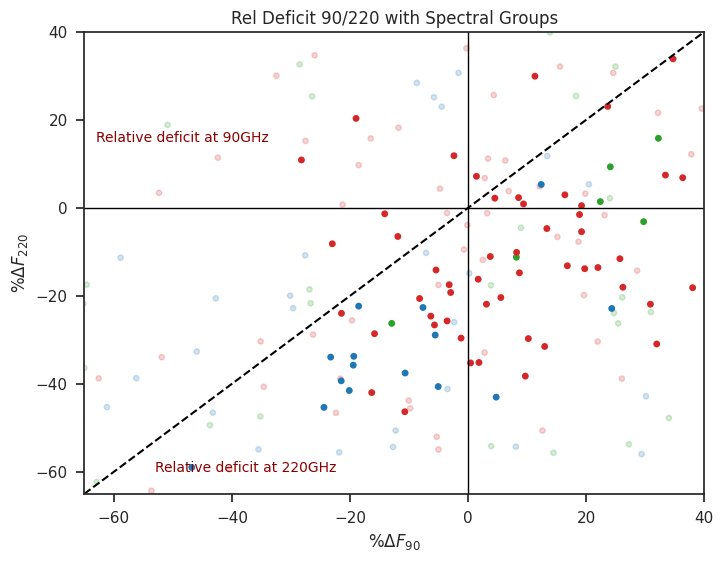

In [38]:
## blue-orange colormap:
import matplotlib.cm as cm

top = cm.get_cmap('Blues_r', 128)
newcolors = np.vstack((top(np.linspace(1, 0, 128))))#,bottom(numpy.linspace(0, 1, 128))))

from matplotlib.colors import ListedColormap
cm.register_cmap('model', cmap = ListedColormap(newcolors))
cmap = 'model'
#######

flags = np.where((sn_090 >=3) & (sn_220>= 3))[0]
flags_5 = np.where((sn_090 >=5) & (sn_220>= 5))[0]

#flags = np.ones(len(delta_090), dtype=bool)

lim = -65

fig, ax = plt.subplots(1,1)

#plt.scatter(delta_090[flags], delta_220[flags], zorder = 2, s = 5, c =sn_220[flags], vmin = 1, vmax = 5, cmap=cmap)
#plt.errorbar(delta_090[flags], delta_220[flags], xerr=delta_090_err[flags], yerr=delta_220_err[flags],
#             fmt='o', alpha = 0.4, ecolor = 'black', zorder = 1, ms = 1, elinewidth = 1.)

#plt.scatter(100*rel_delta_090, 100*rel_delta_220, s=10, zorder = 0, alpha = 0.2)


plt.scatter(100*rel_delta_090[flags], 100*rel_delta_220[flags], zorder = 2, c=colors[flags], s = 15, alpha = 1)

plt.scatter(100*rel_delta_090, 100*rel_delta_220, zorder = 1, c=colors, s = 15, alpha = 0.2)


ax.axhline(0, color = 'black', linewidth=1.)
ax.axvline(0, color = 'black', linewidth=1.)

plt.xlim(lim,40)
plt.ylim(lim,40)

xs = np.linspace(lim, 40)

#cbar = plt.colorbar()
#cbar.set_label('S/n (220GHz)', rotation=270, labelpad = 20)

ax.annotate("Relative deficit at 220GHz", xy = (-20, -20), size = 10, xytext = (-53, -60), color = "darkred")
ax.annotate("Relative deficit at 90GHz", xy = (-20, -20), size = 10, xytext = (-63, 15), color = "darkred")

plt.plot(xs, xs, ls = '--', c = 'black')
plt.xlabel(r'$\%\Delta F_{90}$')
plt.ylabel(r'$\%\Delta F_{220}$')
#handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in color_mapping.items()]
#ax.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Rel Deficit 90/220 with Spectral Groups')
plt.savefig('/home/r/rbond/jorlo/dev/minorplanets/plots/delta_F_090_220_groups.pdf',dpi=600)
plt.savefig('/home/r/rbond/jorlo/dev/minorplanets/plots/delta_F_090_220_groups.png', dpi=600)

In [39]:
flags_C = np.where((groups == 'C'))
flags_S = np.where((groups == 'S'))
flags_X = np.where((groups == 'X'))



In [40]:
ave_090_C, var_090_C = inv_var(rel_delta_090[flags_C], rel_delta_090_err[flags_C])
ave_150_C, var_150_C = inv_var(rel_delta_150[flags_C], rel_delta_150_err[flags_C])
ave_220_C, var_220_C = inv_var(rel_delta_220[flags_C], rel_delta_220_err[flags_C])

ave_090_S, var_090_S = inv_var(rel_delta_090[flags_S], rel_delta_090_err[flags_S])
ave_150_S, var_150_S = inv_var(rel_delta_150[flags_S], rel_delta_150_err[flags_S])
ave_220_S, var_220_S = inv_var(rel_delta_220[flags_S], rel_delta_220_err[flags_S])

ave_090_X, var_090_X = inv_var(rel_delta_090[flags_X], rel_delta_090_err[flags_X])
ave_150_X, var_150_X = inv_var(rel_delta_150[flags_X], rel_delta_150_err[flags_X])
ave_220_X, var_220_X = inv_var(rel_delta_220[flags_X], rel_delta_220_err[flags_X])

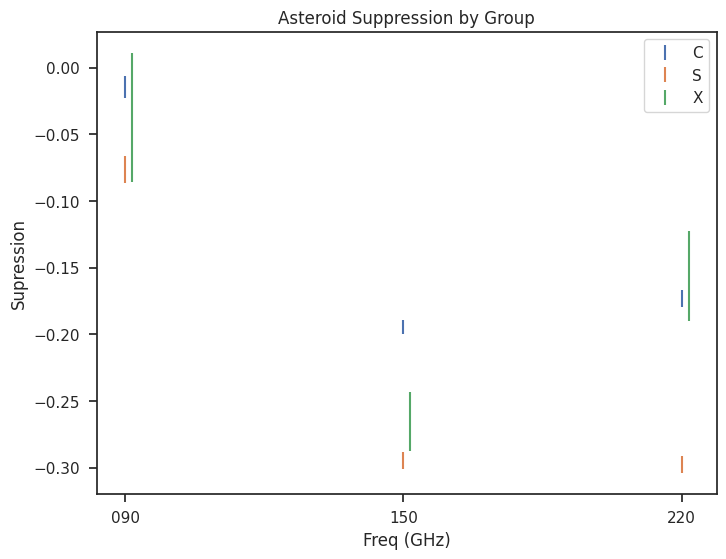

In [41]:
import matplotlib

plt.errorbar([0,1,2], [ave_090_C, ave_150_C, ave_220_C], yerr = [var_090_C, var_150_C, var_220_C], label = 'C', linestyle = 'none')
plt.errorbar([0,1,2], [ave_090_S, ave_150_S, ave_220_S], yerr = [var_090_S, var_150_S, var_220_S], label = 'S', linestyle = 'none')
plt.errorbar([0.025,1.025,2.025], [ave_090_X, ave_150_X, ave_220_X], yerr = [var_090_X, var_150_X, var_220_X], label = 'X', linestyle = 'none')

plt.legend()
locs, labels = plt.xticks()
plt.xticks(np.arange(3), ['090', '150', '220'])
plt.xlabel('Freq (GHz)')
plt.ylabel('Supression')
plt.title('Asteroid Suppression by Group')
plt.savefig('/home/r/rbond/jorlo/dev/minorplanets/plots/sup_groups.pdf',dpi=600)
plt.savefig('/home/r/rbond/jorlo/dev/minorplanets/plots/sup_groups.png', dpi=600)

In [42]:
print('Sup f090, C: {} +\- {}'.format(round(ave_090_C,3), round(var_090_C,3)))
print('Sup f150, C: {} +\- {}'.format(round(ave_150_C,3), round(var_150_C,3)))
print('Sup f220, C: {} +\- {}'.format(round(ave_220_C,3), round(var_220_C,3)))

print('\n')

print('Sup f090, S: {} +\- {}'.format(round(ave_090_S,3), round(var_090_S,3)))
print('Sup f150, S: {} +\- {}'.format(round(ave_150_S,3), round(var_150_S,3)))
print('Sup f220, S: {} +\- {}'.format(round(ave_220_S,3), round(var_220_S,3)))

print('\n')

print('Sup f090, X: {} +\- {}'.format(round(ave_090_X,3), round(var_090_X,3)))
print('Sup f150, X: {} +\- {}'.format(round(ave_150_X,3), round(var_150_X,3)))
print('Sup f220, X: {} +\- {}'.format(round(ave_220_X,3), round(var_220_X,3)))


Sup f090, C: -0.015 +\- 0.008
Sup f150, C: -0.195 +\- 0.005
Sup f220, C: -0.173 +\- 0.006


Sup f090, S: -0.076 +\- 0.01
Sup f150, S: -0.295 +\- 0.006
Sup f220, S: -0.297 +\- 0.006


Sup f090, X: -0.037 +\- 0.049
Sup f150, X: -0.265 +\- 0.022
Sup f220, X: -0.156 +\- 0.033


In [60]:
sn_cut = 5

tholens_C_090 = [100*sup for i, sup in enumerate(rel_delta_090) if tholens[i] == 'C' and tot_sn[i] >= sn_cut]
tholens_S_090 = [100*sup for i, sup in enumerate(rel_delta_090) if tholens[i] == 'S' and tot_sn[i] >= sn_cut]
tholens_M_090 = [100*sup for i, sup in enumerate(rel_delta_090) if tholens[i] == 'M' and tot_sn[i] >= sn_cut]
tholens_X_090 = [100*sup for i, sup in enumerate(rel_delta_090) if tholens[i] == 'X' and tot_sn[i] >= sn_cut]
tholens_P_090 = [100*sup for i, sup in enumerate(rel_delta_090) if tholens[i] == 'P' and tot_sn[i] >= sn_cut]

tholens_C_090_var = [100*sup for i, sup in enumerate(rel_delta_090_err) if tholens[i] == 'C' and tot_sn[i] >= sn_cut]
tholens_S_090_var = [100*sup for i, sup in enumerate(rel_delta_090_err) if tholens[i] == 'S' and tot_sn[i] >= sn_cut]
tholens_M_090_var = [100*sup for i, sup in enumerate(rel_delta_090_err) if tholens[i] == 'M' and tot_sn[i] >= sn_cut]
tholens_X_090_var = [100*sup for i, sup in enumerate(rel_delta_090_err) if tholens[i] == 'X' and tot_sn[i] >= sn_cut]
tholens_P_090_var = [100*sup for i, sup in enumerate(rel_delta_090_err) if tholens[i] == 'P' and tot_sn[i] >= sn_cut]

tholens_C_150 = [100*sup for i, sup in enumerate(rel_delta_150) if tholens[i] == 'C' and tot_sn[i] >= sn_cut]
tholens_S_150 = [100*sup for i, sup in enumerate(rel_delta_150) if tholens[i] == 'S' and tot_sn[i] >= sn_cut]
tholens_M_150 = [100*sup for i, sup in enumerate(rel_delta_150) if tholens[i] == 'M' and tot_sn[i] >= sn_cut]
tholens_X_150 = [100*sup for i, sup in enumerate(rel_delta_150) if tholens[i] == 'X' and tot_sn[i] >= sn_cut]
tholens_P_150 = [100*sup for i, sup in enumerate(rel_delta_150) if tholens[i] == 'P' and tot_sn[i] >= sn_cut]

tholens_C_150_var = [100*sup for i, sup in enumerate(rel_delta_150_err) if tholens[i] == 'C' and tot_sn[i] >= sn_cut]
tholens_S_150_var = [100*sup for i, sup in enumerate(rel_delta_150_err) if tholens[i] == 'S' and tot_sn[i] >= sn_cut]
tholens_M_150_var = [100*sup for i, sup in enumerate(rel_delta_150_err) if tholens[i] == 'M' and tot_sn[i] >= sn_cut]
tholens_X_150_var = [100*sup for i, sup in enumerate(rel_delta_150_err) if tholens[i] == 'X' and tot_sn[i] >= sn_cut]
tholens_P_150_var = [100*sup for i, sup in enumerate(rel_delta_150_err) if tholens[i] == 'P' and tot_sn[i] >= sn_cut]

tholens_C_220 = [100*sup for i, sup in enumerate(rel_delta_220) if tholens[i] == 'C' and tot_sn[i] >= sn_cut]
tholens_S_220 = [100*sup for i, sup in enumerate(rel_delta_220) if tholens[i] == 'S' and tot_sn[i] >= sn_cut]
tholens_M_220 = [100*sup for i, sup in enumerate(rel_delta_220) if tholens[i] == 'M' and tot_sn[i] >= sn_cut]
tholens_X_220 = [100*sup for i, sup in enumerate(rel_delta_220) if tholens[i] == 'X' and tot_sn[i] >= sn_cut]
tholens_P_220 = [100*sup for i, sup in enumerate(rel_delta_220) if tholens[i] == 'P' and tot_sn[i] >= sn_cut]

tholens_C_220_var = [100*sup for i, sup in enumerate(rel_delta_220_err) if tholens[i] == 'C' and tot_sn[i] >= sn_cut]
tholens_S_220_var = [100*sup for i, sup in enumerate(rel_delta_220_err) if tholens[i] == 'S' and tot_sn[i] >= sn_cut]
tholens_M_220_var = [100*sup for i, sup in enumerate(rel_delta_220_err) if tholens[i] == 'M' and tot_sn[i] >= sn_cut]
tholens_X_220_var = [100*sup for i, sup in enumerate(rel_delta_220_err) if tholens[i] == 'X' and tot_sn[i] >= sn_cut]
tholens_P_220_var = [100*sup for i, sup in enumerate(rel_delta_220_err) if tholens[i] == 'P' and tot_sn[i] >= sn_cut]

tholens_C_names = [name for i, name in enumerate(names) if tholens[i] == 'C' and tot_sn[i] >= sn_cut]
tholens_S_names = [name for i, name in enumerate(names) if tholens[i] == 'S' and tot_sn[i] >= sn_cut]
tholens_M_names = [name for i, name in enumerate(names) if tholens[i] == 'M' and tot_sn[i] >= sn_cut]
tholens_X_names = [name for i, name in enumerate(names) if tholens[i] == 'X' and tot_sn[i] >= sn_cut]
tholens_P_names = [name for i, name in enumerate(names) if tholens[i] == 'P' and tot_sn[i] >= sn_cut]

In [57]:
ave_090_C, var_090_C = inv_var(tholens_C_090, np.array(tholens_C_090_var)**2)
ave_090_S, var_090_S = inv_var(tholens_S_090, np.array(tholens_S_090_var)**2)
ave_090_M, var_090_M = inv_var(tholens_M_090, np.array(tholens_M_090_var)**2)
ave_090_X, var_090_X = inv_var(tholens_X_090, np.array(tholens_X_090_var)**2)
ave_090_P, var_090_P = inv_var(tholens_P_090, np.array(tholens_P_090_var)**2)

ave_150_C, var_150_C = inv_var(tholens_C_150, np.array(tholens_C_150_var)**2)
ave_150_S, var_150_S = inv_var(tholens_S_150, np.array(tholens_S_150_var)**2)
ave_150_M, var_150_M = inv_var(tholens_M_150, np.array(tholens_M_150_var)**2)
ave_150_X, var_150_X = inv_var(tholens_X_150, np.array(tholens_X_150_var)**2)
ave_150_P, var_150_P = inv_var(tholens_P_150, np.array(tholens_P_150_var)**2)

ave_220_C, var_220_C = inv_var(tholens_C_220, np.array(tholens_C_220_var)**2)
ave_220_S, var_220_S = inv_var(tholens_S_220, np.array(tholens_S_220_var)**2)
ave_220_M, var_220_M = inv_var(tholens_M_220, np.array(tholens_M_220_var)**2)
ave_220_X, var_220_X = inv_var(tholens_X_220, np.array(tholens_X_220_var)**2)
ave_220_P, var_220_P = inv_var(tholens_P_220, np.array(tholens_P_220_var)**2)

var_090_C = np.sqrt(var_090_C)
var_090_S = np.sqrt(var_090_S)
var_090_M = np.sqrt(var_090_M)
var_090_X = np.sqrt(var_090_X)
var_090_P = np.sqrt(var_090_P)

var_150_C = np.sqrt(var_150_C)
var_150_S = np.sqrt(var_150_S)
var_150_M = np.sqrt(var_150_M)
var_150_X = np.sqrt(var_150_X)
var_150_P = np.sqrt(var_150_P)

var_220_C = np.sqrt(var_220_C)
var_220_S = np.sqrt(var_220_S)
var_220_M = np.sqrt(var_220_M)
var_220_X = np.sqrt(var_220_X)
var_220_P = np.sqrt(var_220_P)

In [58]:
print('Sup f090, C: {} +\- {}'.format(round(ave_090_C,3), round(var_090_C,3)))
print('Sup f150, C: {} +\- {}'.format(round(ave_150_C,3), round(var_150_C,3)))
print('Sup f220, C: {} +\- {}'.format(round(ave_220_C,3), round(var_220_C,3)))

print('\n')

print('Sup f090, S: {} +\- {}'.format(round(ave_090_S,3), round(var_090_S,3)))
print('Sup f150, S: {} +\- {}'.format(round(ave_150_S,3), round(var_150_S,3)))
print('Sup f220, S: {} +\- {}'.format(round(ave_220_S,3), round(var_220_S,3)))

print('\n')

print('Sup f090, M: {} +\- {}'.format(round(ave_090_M,3), round(var_090_M,3)))
print('Sup f150, M: {} +\- {}'.format(round(ave_150_M,3), round(var_150_M,3)))
print('Sup f220, M: {} +\- {}'.format(round(ave_220_M,3), round(var_220_M,3)))

print('\n')

print('Sup f090, X: {} +\- {}'.format(round(ave_090_X,3), round(var_090_X,3)))
print('Sup f150, X: {} +\- {}'.format(round(ave_150_X,3), round(var_150_X,3)))
print('Sup f220, X: {} +\- {}'.format(round(ave_220_X,3), round(var_220_X,3)))

print('\n')

print('Sup f090, P: {} +\- {}'.format(round(ave_090_P,3), round(var_090_P,3)))
print('Sup f150, P: {} +\- {}'.format(round(ave_150_P,3), round(var_150_P,3)))
print('Sup f220, P: {} +\- {}'.format(round(ave_220_P,3), round(var_220_P,3)))

Sup f090, C: 0.077 +\- 3.211
Sup f150, C: -20.219 +\- 1.428
Sup f220, C: -23.169 +\- 1.93


Sup f090, S: -18.735 +\- 3.867
Sup f150, S: -40.137 +\- 1.729
Sup f220, S: -33.751 +\- 2.54


Sup f090, M: -41.648 +\- 17.602
Sup f150, M: -47.952 +\- 8.001
Sup f220, M: -31.519 +\- 11.656


Sup f090, X: 12.954 +\- 20.269
Sup f150, X: -20.495 +\- 9.5
Sup f220, X: -0.189 +\- 14.902


Sup f090, P: -10.071 +\- 9.197
Sup f150, P: -31.599 +\- 4.233
Sup f220, P: -23.846 +\- 6.398


In [59]:
print('# C: {}'.format(len(tholens_C_090)))
print('# S: {}'.format(len(tholens_S_090)))
print('# M: {}'.format(len(tholens_M_090)))
print('# X: {}'.format(len(tholens_X_090)))
print('# P: {}'.format(len(tholens_P_090)))

# C: 109
# S: 168
# M: 32
# X: 28
# P: 19


In [47]:
print(r'090/150, C type =', round(ave_090_C/ave_150_C,3), round(ave_090_C/ave_150_C*np.sqrt((var_150_C/ave_150_C)**2+(var_090_C/ave_090_C)**2),3))
print(r'090/150, S type =', round(ave_090_S/ave_150_S,3), round(ave_090_S/ave_150_S*np.sqrt((var_150_S/ave_150_S)**2+(var_090_S/ave_090_S)**2),3))

print(r'150/220, C type =', round(ave_150_C/ave_220_C,3), round(ave_150_C/ave_220_C*np.sqrt((var_150_C/ave_150_C)**2+(var_220_C/ave_220_C)**2),3))
print(r'150/220, S type =', round(ave_150_S/ave_220_S,3), round(ave_150_S/ave_220_S*np.sqrt((var_150_S/ave_150_S)**2+(var_220_S/ave_220_S)**2),3))

090/150, C type = -0.004 -0.159
090/150, S type = 0.467 0.098
150/220, C type = 0.873 0.095
150/220, S type = 1.189 0.103


In [48]:
data_090 = [tholens_C_090, tholens_S_090, tholens_M_090, tholens_X_090, tholens_P_090]
data_150 = [tholens_C_150, tholens_S_150, tholens_M_150, tholens_X_150, tholens_P_150]
data_220 = [tholens_C_220, tholens_S_220, tholens_M_220, tholens_X_220, tholens_P_220]

means_090 = [ave_090_C, ave_090_S, ave_090_M, ave_090_X, ave_090_P]
means_150 = [ave_150_C, ave_150_S, ave_150_M, ave_150_X, ave_150_P]
means_220 = [ave_220_C, ave_220_S, ave_220_M, ave_220_X, ave_220_P]

errs_090 = [var_090_C, var_090_S, var_090_M, var_090_X, var_090_P]
errs_150 = [var_150_C, var_150_S, var_150_M, var_150_X, var_150_P]
errs_220 = [var_220_C, var_220_S, var_220_M, var_220_X, var_220_P]

means_090 = np.array(means_090)
means_150 = np.array(means_150)
means_220 = np.array(means_220)

errs_090 = np.array(errs_090)
errs_150 = np.array(errs_150)
errs_220 = np.array(errs_220)

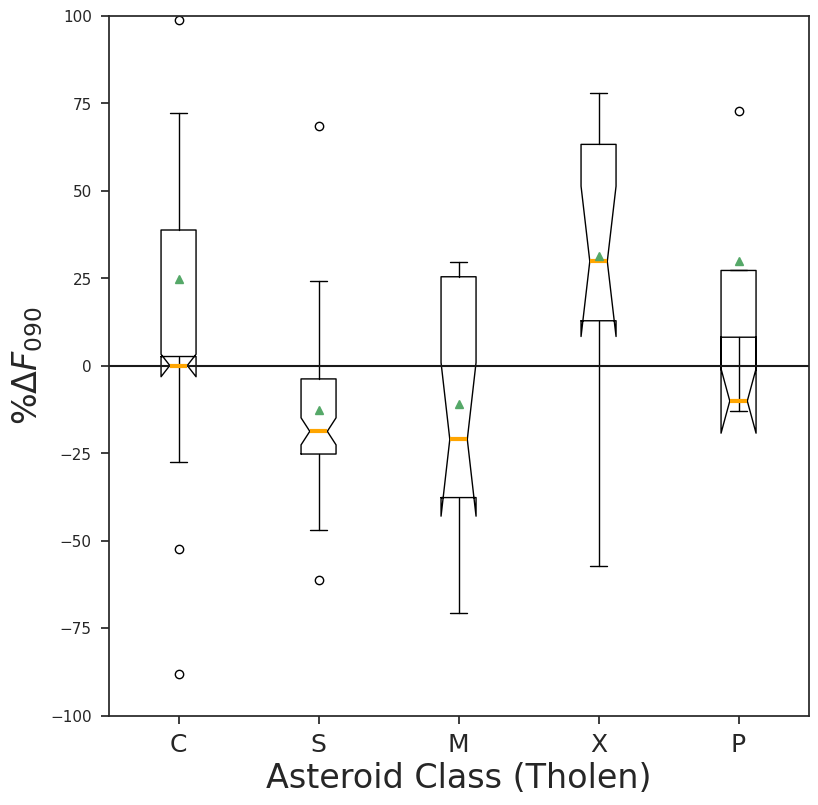

In [49]:
fig = plt.figure(figsize =(7, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

medianprops = dict(linestyle='-.', linewidth=3, color='orange')

# Creating plot
bp = ax.boxplot(data_090, usermedians = means_090, notch = True, widths = 0.25, bootstrap  = 5000, showmeans=True,
                medianprops=medianprops, conf_intervals = np.array([means_090-errs_090, means_090 + errs_090]).T)
ax.set_ylim(-100, 100) 
ax.set_xticklabels(['C', 'S', 'M', 'X', 'P'], fontsize=18)
#plt.title('Individual Sups, f090')

ax.axhline(y=0, color='k', zorder = 2)

ax.set_xlabel("Asteroid Class (Tholen)", fontsize=24)
ax.set_ylabel(r'$\%\Delta F_{090}$', fontsize=24)

plt.savefig('./plots/class_box_090.pdf', bbox_inches='tight', dpi=600)
plt.savefig('./plots/class_box_090.png', bbox_inches='tight', dpi=600)

plt.show()

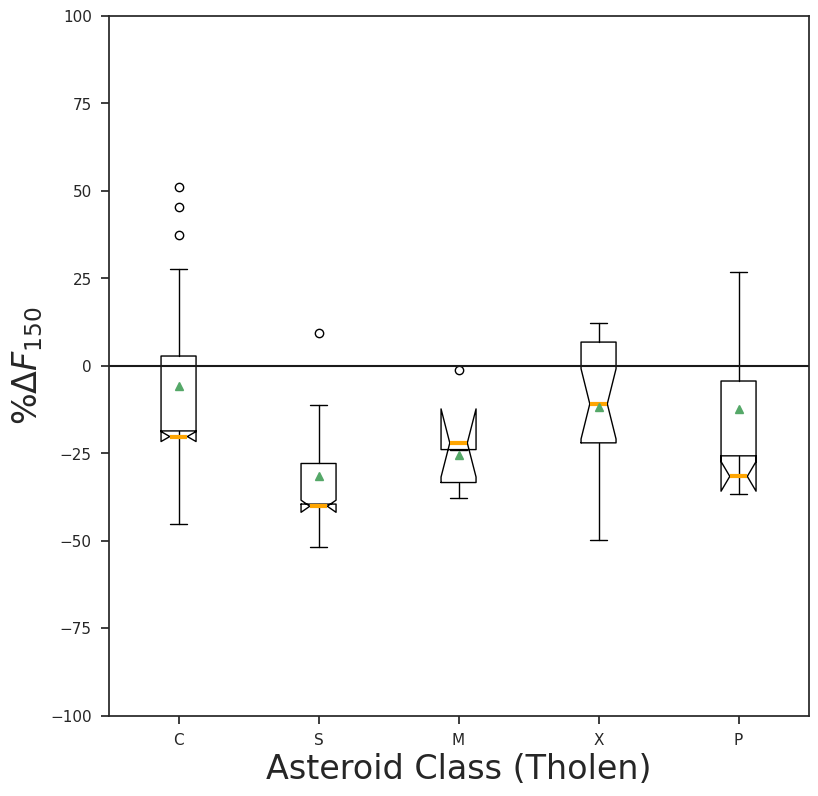

In [50]:
fig = plt.figure(figsize =(7, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
medianprops = dict(linestyle='-.', linewidth=3, color='orange')    
    
# Creating plot
bp = ax.boxplot(data_150, usermedians = means_150, notch = True, widths = 0.25,  bootstrap  = 5000, showmeans=True,
                medianprops=medianprops, conf_intervals = np.array([means_150-errs_150, means_150 + errs_150]).T)
ax.set_ylim(-100, 100) 
ax.set_xticklabels(['C', 'S', 'M', 'X', 'P'])

ax.axhline(y=0, color='k', zorder = 2)

ax.set_xlabel("Asteroid Class (Tholen)", fontsize=24)
ax.set_ylabel(r'$\%\Delta F_{150}$', fontsize=24)

# show plot
plt.savefig('./plots/class_box_150.pdf', bbox_inches='tight', dpi=600)
plt.savefig('./plots/class_box_150.png', bbox_inches='tight', dpi=600)
plt.show()

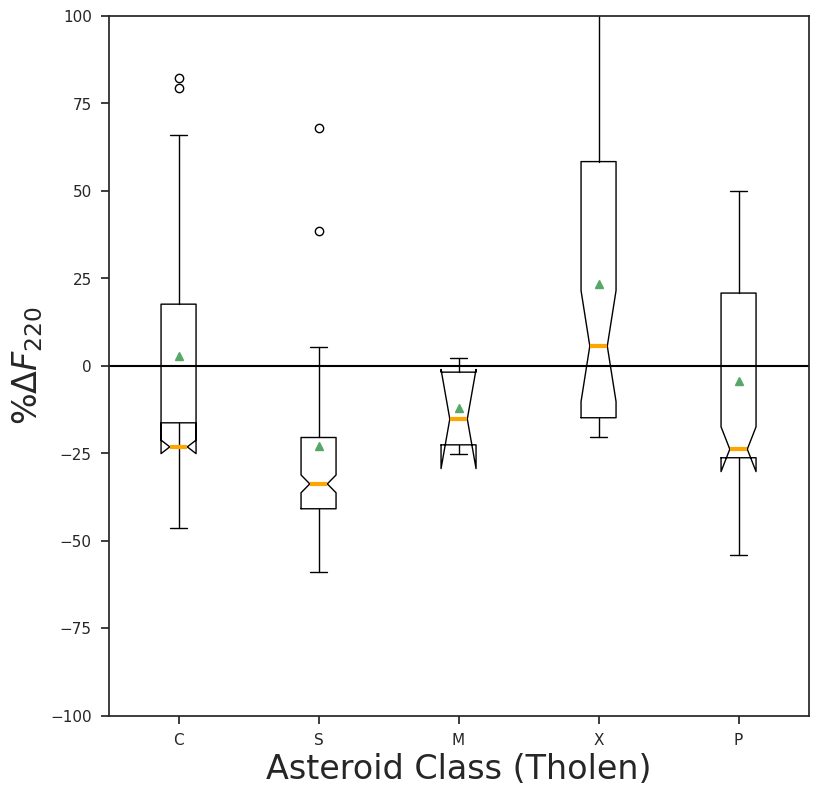

In [51]:
fig = plt.figure(figsize =(7, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
medianprops = dict(linestyle='-.', linewidth=3, color='orange')    
    
# Creating plot
bp = ax.boxplot(data_220, usermedians = means_220, notch = True, widths = 0.25, bootstrap  = 5000, showmeans=True,
                medianprops=medianprops, conf_intervals = np.array([means_220-errs_220, means_220 + errs_220]).T)
ax.set_ylim(-100, 100) 
ax.set_xticklabels(['C', 'S', 'M', 'X', 'P'])
#plt.title('Individual Sups, f220')

ax.axhline(color='black', zorder = 2)

ax.set_xlabel("Asteroid Class (Tholen)", fontsize=24)
ax.set_ylabel(r'$\%\Delta F_{220}$', fontsize=24)

plt.savefig('./plots/class_box_220.pdf', bbox_inches='tight', dpi=600)
plt.savefig('./plots/class_box_220.png', bbox_inches='tight', dpi=600)
plt.show()

/tmp/ipykernel_239480/2465368942.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax090.set_xticklabels(['ignore', 'C', 'S', 'M', 'X', 'P'])
/tmp/ipykernel_239480/2465368942.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax150.set_xticklabels(['ignore', 'C', 'S', 'M', 'X', 'P'])
/tmp/ipykernel_239480/2465368942.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax220.set_xticklabels(['ignore', 'C', 'S', 'M', 'X', 'P'])


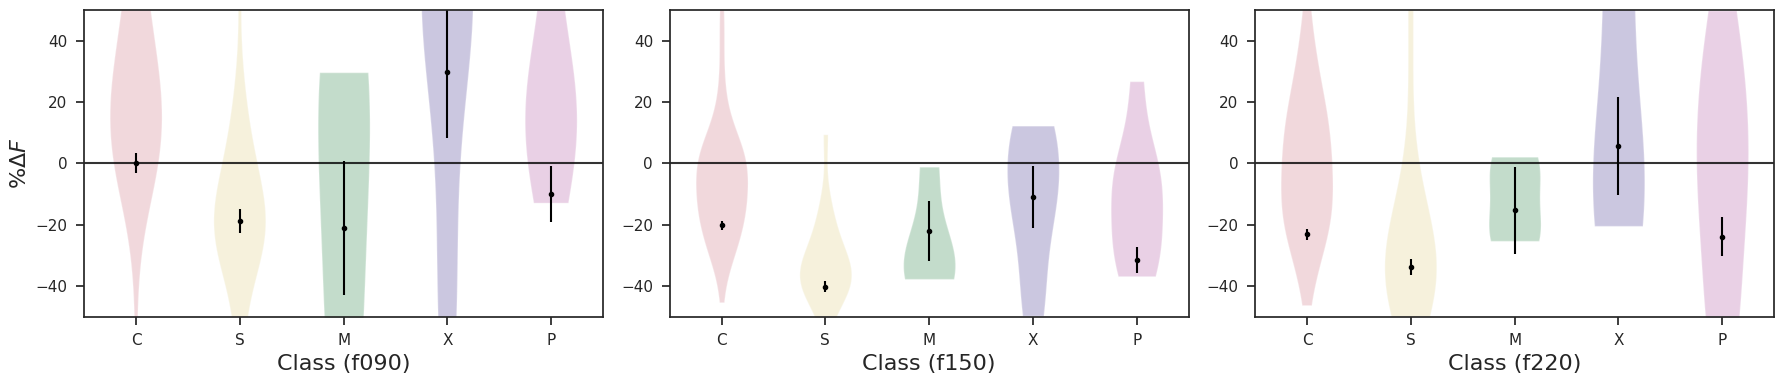

In [52]:
from palettable.cartocolors.qualitative import Safe_6

fig = plt.figure(figsize=(18, 4))
ax090= fig.add_subplot(1,3,1)
ax150= fig.add_subplot(1,3,2)
ax220= fig.add_subplot(1,3,3)

colors = np.array(Safe_6.colors[1:])/256

ax090.errorbar([1,2,3,4, 5], y=means_090, yerr = errs_090, linestyle='none', fmt='.', color = 'black')
ax090.set_xticklabels(['ignore', 'C', 'S', 'M', 'X', 'P'])
ax090.set_xlim(0.5, 5.5)

ax150.errorbar([1,2,3,4, 5], y=means_150, yerr = errs_150, linestyle='none', fmt='.', color = 'black')
ax150.set_xticklabels(['ignore', 'C', 'S', 'M', 'X', 'P'])
ax150.set_xlim(0.5, 5.5)

ax220.errorbar([1,2,3,4, 5], y=means_220, yerr = errs_220, linestyle='none', fmt='.', color =  'black')
ax220.set_xticklabels(['ignore', 'C', 'S', 'M', 'X', 'P'])
ax220.set_xlim(0.5, 5.5)

ax090.set_ylim(-50, 50) 
ax150.set_ylim(-50, 50) 
ax220.set_ylim(-50, 50) 

ax090.axhline(color='black', zorder = 2, alpha = 0.8)
ax150.axhline(color='black', zorder = 2, alpha = 0.8)
ax220.axhline(color='black', zorder = 2, alpha = 0.8)


parts = ax090.violinplot(data_090,
        #[data_090[i] if len(data_090[i]) > 10 else np.zeros(len(data_090[i])) for i in range(len(data_090))], 
        showmeans=False, showmedians=False, showextrema=False)

for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.25)
    
parts = ax150.violinplot(data_150, 
        #[data_150[i] if len(data_150[i]) > 10 else np.zeros(len(data_150[i])) for i in range(len(data_150))],
        showmeans=False, showmedians=False, showextrema=False)

for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.25)

parts = ax220.violinplot(data_220,
        #[data_220[i] if len(data_220[i]) > 10 else np.zeros(len(data_220[i])) for i in range(len(data_220))],
        showmeans=False, showmedians=False, showextrema=False)

for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.25)
    
ax090.set_xlabel('Class (f090)', size=16)
ax150.set_xlabel('Class (f150)', size=16)
ax220.set_xlabel('Class (f220)', size=16)

ax090.set_ylabel(r'$\%\Delta F$', size=16)
#ax150.set_ylabel(r'$\%\Delta F_{150}$', size=16)
#ax220.set_ylabel(r'$\%\Delta F_{220}$', size=16)

plt.tight_layout()
plt.savefig('/home/r/rbond/jorlo/dev/minorplanets/plots/ast_class.pdf', dpi=600)
plt.savefig('/home/r/rbond/jorlo/dev/minorplanets/plots/ast_class.png', dpi=600)

plt.show()

# Class Bootstrapping

In [53]:
def bootstrap(data, n = 10000):
    data = np.array(data)

    temp = np.zeros(n)
    for i in range(n):
        flags = np.random.randint(len(data), size = len(data))
        temp[i] = np.mean(data[flags])

    return temp

def bootstrap2(flux1, flux2, n = 10000):
    flux1 = np.array(flux1)
    flux2 = np.array(flux2)

    temp = np.zeros(n)
    for i in range(n):
        flags = np.random.randint(len(flux1), size = len(flux1))
        temp_flux1, temp_flux2 = flux1[flags], flux2[flags]
        
        temp[i] = np.mean(temp_flux1)/np.mean(temp_flux2)

    return temp

In [54]:
tholens_C_diff_090_150 = np.array(tholens_C_090)-np.array(tholens_C_150)
tholens_S_diff_090_150 = np.array(tholens_S_090)-np.array(tholens_S_150)

tholens_C_diff_150_220 = np.array(tholens_C_150)-np.array(tholens_C_220)
tholens_S_diff_150_220 = np.array(tholens_S_150)-np.array(tholens_S_220)

boot_C_diff_090_150 = bootstrap(tholens_C_diff_090_150)
boot_S_diff_090_150 = bootstrap(tholens_S_diff_090_150)

boot_C_diff_150_220 = bootstrap(tholens_C_diff_150_220)
boot_S_diff_150_220 = bootstrap(tholens_S_diff_150_220)

In [55]:
print(np.mean(boot_C_diff_090_150), np.std(boot_C_diff_090_150))
print(np.mean(boot_S_diff_090_150), np.std(boot_S_diff_090_150))

print(np.mean(boot_C_diff_150_220), np.std(boot_C_diff_150_220))
print(np.mean(boot_S_diff_150_220), np.std(boot_S_diff_150_220))

30.76849273822442 4.568220801072906
18.957323841121227 3.9907153406795843
-8.539586735515572 2.792349067298392
-8.635536227918786 6.0392821833337615
